In [1]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('lines', linewidth=5)
rc('text', usetex=True)

import cmasher as cmr

In [2]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [3]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [4]:
def plot_bar_data(data_df,x_col="x",series_readable_id_col="name", fig_size=(8, 5), series_readable_id_map=None, x_label=None, y_label=None, y_lim=None, y_tick_spec=None, y_err_df = None, all_groups = None, overall_position_list=None, special_color_map=None, num_colors=None, title="Figure Title", grid=True, save_path=None, show=True):

    # make a simple bar chart of the data labellinig each by it's series_readable_id_col
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    
    #plot using plt.bar
    # but lets make subplots for heirarchical groups
    # first level, on left we want bars where name contains 50_200 and right is where name has 100_600
    # in each of those groups, we want to split into set where contains cp_attack and where doesn't
    # them finally we sort each final group by x_col
    # mak sure we position them separately on the x axis with some space between them

    fig, ax = plt.subplots(figsize=fig_size)

    global_idx = 0
    all_labels = []
    for i, grp in enumerate(all_groups):
        if isinstance(series_readable_id_map, dict):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(series_readable_id_map)
        elif isinstance(series_readable_id_map, Callable):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(lambda x: series_readable_id_map(x))

        for j, x_val in enumerate(grp[x_col]):
            label = grp[series_readable_id_col].iloc[j]
            all_labels.append(label)
            color = cmap[j]
            ax.bar(overall_position_list[global_idx], x_val, color=color, alpha=0.8)
            # if y_err_df is not None:
            if y_err_df is not None and label in y_err_df[series_readable_id_col].values:
                print(label)
                print(y_err_df[series_readable_id_col].values)
                y_err = y_err_df[y_err_df[series_readable_id_col] == label][x_col]
                print(y_err)
                ax.errorbar(overall_position_list[global_idx], x_val, yerr=y_err, fmt="none", ecolor="black", capsize=5, capthick=2, zorder=10, elinewidth=2)


            global_idx += 1

    # Set the x ticks to be the names located at the center of the correct bar
    ax.set_xticks(overall_position_list, all_labels)


    # turn on grid  
    ax.set_axisbelow(True)
    ax.grid(grid,zorder=0,axis="y")
    # increase horiz grid density 
    ax.xaxis.grid(which="minor", linestyle="-", linewidth=0.5, color="black", zorder=0)
    if y_tick_spec is not None:
        ax.set_yticks(y_tick_spec)

    

    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_label)
    plt.ylabel(y_label if y_label else x_col)

    # set y lim to be 0 to 1
    ax.set_ylim(y_lim)

    # angle labels
    plt.xticks(rotation=45, ha="right")

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [5]:
def name_extractor(x):
    x = x.replace("gpt_p", "Prompt ")
    x = x.replace("core", "")
    x = x.replace("eval", "")
    x = x.replace("simple_1", "")
    
    x = x.replace("_", " ")

    if "50 200" in x:
        x = x.replace("50 200", "")
        # x = "T=200, " + x
    elif "100 600" in x:
        x = x.replace("100 600", "")
        # x = "T=600, " + x
    elif "200 1000" in x:
        x = x.replace("200 1000", "")
        # x = "T=1000, " + x
    return x


In [6]:
fig_name = "prompt_ablation_attacked_AUC"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,Name,_wandb,attacked_z_score_roc_auc
0,core_simple_1_100_600_gpt_p3_eval,NaN,0.933752
1,core_simple_1_100_600_gpt_p4_eval,NaN,0.922727
2,core_simple_1_100_600_gpt_p0_eval,NaN,0.895125


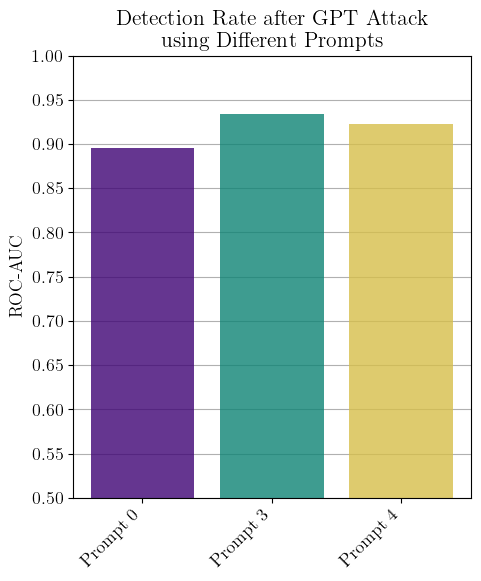

In [7]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})


df = df.sort_values(by=["Name"])

all_groups = [df]

# hardcode 27 bar positions leaving out the 3 required for the gaps
# 6 bars per group, 4 groups, 3 gaps
# width is 7 bars - the 1 gap bar
width = 2 

widths = [3]

offset = 0

overall_position_list = []
for width in widths:
    overall_position_list += list(range(offset, offset+width))
    offset += width + 1

plot_bar_data(
    df,
    x_col="attacked_z_score_roc_auc",
    # x_label="Watermarking Settings",
    y_label="ROC-AUC",
    fig_size=(5,6),
    y_lim=(0.5,1.0),
    y_tick_spec=np.arange(0, 1.1, 0.05),
    series_readable_id_col="Name",
    all_groups=all_groups,
    overall_position_list=overall_position_list,
    num_colors = 3,
    series_readable_id_map=name_extractor,
    title="Detection Rate after GPT Attack\nusing Different Prompts",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
    show=True
)
    

In [8]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

fig_name = "prompt_ablation_lengths"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
# df

In [9]:
df["Name"] = df["Name"].apply(name_extractor)

df = df.sort_values(by=["Name"])

# create a df with a single length column, where each row's Name field is its original name + the length col type
# the original length cols are  ["f_600p25m25_w_wm_output_attacked_length_mean", "f_600p25m25_w_wm_output_length_mean","f_600p25m25_w_wm_output_attacked_length_std"]

df = df.rename(columns={"f_600p25m25_w_wm_output_num_tokens_scored_mean": "Original", "f_600p25m25_w_wm_output_attacked_num_tokens_scored_mean": "Attacked", "f_600p25m25_w_wm_output_attacked_num_tokens_scored_std": "Attacked Std"})

df = df.melt(id_vars=["Name"], value_vars=["Attacked", "Original", "Attacked Std"], var_name="Length Type", value_name="Length")

# then combine the id and var name to make a new name
df["Name"] = df["Name"].str.strip() + " " + df["Length Type"].str.strip()

# make a group for each of the value var types
all_groups = []
for var_name in ["Original", "Attacked"]:
    all_groups.append(df[df["Length Type"] == var_name].drop(columns=["Length Type"]))

# df = df.drop(columns=["Length Type"])

# extract the std col as a separate df
df_std = df[df["Name"].str.contains("Std")]
# and strip the "Std" from the name
df_std["Name"] = df_std["Name"].str.replace(" Std", "").str.strip()

# turn the std col into the stderr
# N_values = {"Prompt 3": 1064,"Prompt 4": 1064, "Prompt 0": 1064}
# N_value = 1064
# df_std["Length"] = df_std["Length"] / np.sqrt(N_value)

# df

/tmp/ipykernel_1092222/3907533305.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_std["Name"] = df_std["Name"].str.replace(" Std", "").str.strip()


Prompt 0 Attacked
['Prompt 0 Attacked' 'Prompt 3 Attacked' 'Prompt 4 Attacked']
6    112.702214
Name: Length, dtype: float64
Prompt 3 Attacked
['Prompt 0 Attacked' 'Prompt 3 Attacked' 'Prompt 4 Attacked']
7    129.67184
Name: Length, dtype: float64
Prompt 4 Attacked
['Prompt 0 Attacked' 'Prompt 3 Attacked' 'Prompt 4 Attacked']
8    130.09471
Name: Length, dtype: float64


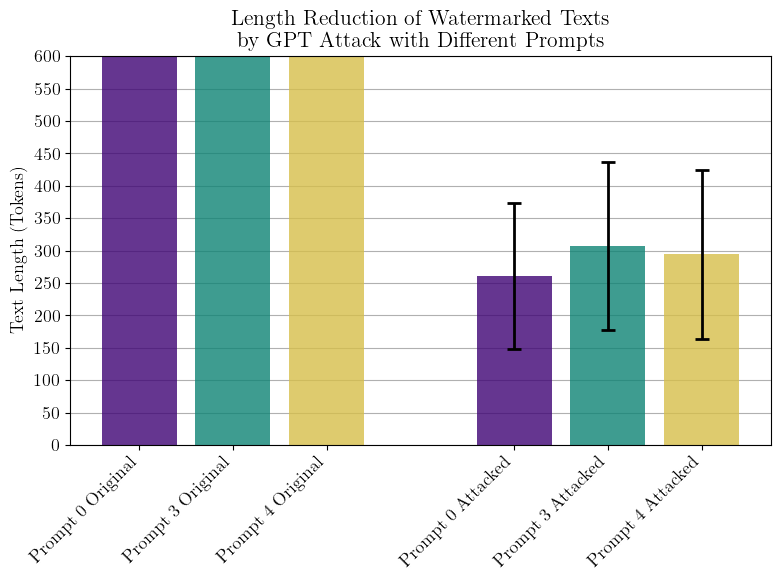

In [10]:
width = 2 # -1 for the gap
widths = [3, 3]
offset = 0

overall_position_list = []
for width in widths:
    overall_position_list += list(range(offset, offset+width))
    offset += width + 1

plot_bar_data(
    df,
    x_col="Length",
    # x_label="Watermarking Settings",
    y_label="Text Length (Tokens)",
    y_lim=(0, 601),
    y_tick_spec=np.arange(0, 601, 50),
    y_err_df=df_std,
    fig_size=(8,6),
    series_readable_id_col="Name",
    all_groups=all_groups,
    overall_position_list=overall_position_list,
    num_colors = 3,
    series_readable_id_map=name_extractor,
    title="Length Reduction of Watermarked Texts\nby GPT Attack with Different Prompts",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
    show=True
)
    

In [11]:
# fig_name = "prompt_ablation_z_scores"

# data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

# df = get_data_df(data_dir)
# df

In [12]:
# df["Name"] = df["Name"].apply(name_extractor)

# df = df.sort_values(by=["Name"])

# df = df.rename(columns={"f_600p25m25_w_wm_output_z_score_mean": "Original", "f_600p25m25_w_wm_output_attacked_z_score_mean": "Attacked", "f_600p25m25_w_wm_output_attacked_z_score_std": "Attacked Std"})

# df = df.melt(id_vars=["Name"], value_vars=["Attacked", "Original", "Attacked Std"], var_name="Type", value_name="z-score")

# df["Name"] = df["Name"].str.strip() + " " + df["Type"].str.strip()

# # make a group for each of the value var types
# all_groups = []
# for var_name in ["Original", "Attacked"]:
#     all_groups.append(df[df["Type"] == var_name].drop(columns=["Type"]))

# # df = df.drop(columns=["Length Type"])

# # extract the std col as a separate df
# df_std = df[df["Name"].str.contains("Std")]
# # and strip the "Std" from the name
# df_std["Name"] = df_std["Name"].str.replace(" Std", "").str.strip()

# # turn the std col into the stderr
# # N_values = {"Prompt 3": 1064,"Prompt 4": 1064, "Prompt 0": 1064}
# # N_value = 1064
# # df_std["Length"] = df_std["Length"] / np.sqrt(N_value)

# df

In [13]:
# width = 2 # -1 for the gap
# widths = [3, 3]
# offset = 0

# overall_position_list = []
# for width in widths:
#     overall_position_list += list(range(offset, offset+width))
#     offset += width + 1

# plot_bar_data(
#     df,
#     x_col="z-score",
#     # x_label="Watermarking Settings",
#     y_label="Z-Score",
#     y_lim=(0, 20),
#     y_tick_spec=np.arange(0, 20, 2),
#     y_err_df=df_std,
#     series_readable_id_col="Name",
#     all_groups=all_groups,
#     overall_position_list=overall_position_list,
#     num_colors = 3,
#     series_readable_id_map=name_extractor,
#     title="Z-Score after GPT Attack w/ Different Prompts",
#     save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
#     show=True
# )
    